# Statistical Hypothesis Test


## Importing the dataset


In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/shannentan22/Group-10-Ivermectin/main/Dataset.csv"
df = pd.read_csv(url)

## Perform the appropriate statistical test based on the hypothesis.

In [ ]:
from scipy.stats import chisquare

rows = len(df.index)
f_obs = df.groupby("Theme").size().to_numpy()
f_obs = [f_obs[0], f_obs[1]+f_obs[2]]
rows = sum(f_obs)
f_exp = [rows/2, rows/2]

print("Observed values:", f_obs[:2])
print("Expected values:", f_exp)

chisq, p = chisquare(f_obs[:2], f_exp=f_exp)

Observed values: [34, 67]
Expected values: [50.5, 50.5]


## Identify and validate the assumptions of the chosen statistical model. Discuss any violations of assumptions and their potential impact on the results.

Assumptions of the Chi-Square Test

1. Independence: The Tweet data were collected in a way that ensures independence between them.

2. Sample Size: With a sample size of 100 and the expected frequencies in each cell being greater than 5, this assumption holds true.

3. Random Sampling: Unfortunately, our data was not randomly sampled. We simply searched for any Tweet that contained information related to our topic and chose the first few.

4. Categorical Variables: The 'Theme' variable is categorical, which is appropriate for the chi-square test.

Impact on the Results:

Since we did not use random sampling, it is possible that our results may be biased and we have limited generalizability. This would lead to misleading conclusions.

## Clearly report the test statistics, p-values, and any effect size measures.

In [ ]:
print("Chi-squared test statistic:", chisq)
print("p-value:", p)

Chi-squared test statistic: 10.782178217821782
p-value: 0.0010248201237150051


## Interpret the results and provide a conclusion based on the hypothesis test.

With a chi-square statistic of 10.7821 and a p-value of 0.0010 that is less than the 0.05 alpha value, it suggests that there is a significant difference between the expected and observed frequencies. With that, we can conclude that the number of anecdotal Tweets is significantly not large compared to the number of non-anecdotal Tweets.

Hence, we accept our null hypothesis:

> Not a large percentage of Tweets about the benefits of Ivermectin in curing COVID-19 were only based on anecdotal evidence.

# Machine Learning - Chosen Model: Sentiment Analysis

## Describe the structure and mechanism of the chosen model.

In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load datasets
url = "https://raw.githubusercontent.com/shannentan22/Group-10-Ivermectin/main/Dataset.csv"
# url = "https://raw.githubusercontent.com/shannentan22/Group-10-Ivermectin/main/NLP_df.csv"

df_senti = pd.read_csv(url)
columns_to_keep = ['Tweet Translated', 'Theme']
# columns_to_keep = ['Lemmatized', 'Theme']
df_senti.drop(df_senti.columns.difference(columns_to_keep), axis=1, inplace=True)

df_senti = df_senti.rename(columns={'Tweet Translated': 'tweet'})
# df_senti = df_senti.rename(columns={'Lemmatized': 'tweet'})
df_senti = df_senti.rename(columns={'Theme': 'sentiment'})

df_senti.head()

,tweet,sentiment
0,@GMA\n lied four days ago in their clip about ...,Anecdotal
1,"It's true Ivermectin works, been a covid survi...",Anecdotal
2,This is the true cure to covid 19!!! Clearance...,Factual
3,"I don’t understand why some staff and friends,...",Anecdotal
4,"i sent the link, I'm unfortunate. their sister...",Anecdotal


In [ ]:
## Plot sentiment distributions
import plotly.express as px

# sentiment_labels = {0: 'Anecdotal', 1: 'Factual', 2: 'None'}
sentiment_colors = ['#c0392b', '#2c3e50', '#16a085']
# df_senti['sentiment_label'] = df_senti['sentiment'].map(sentiment_labels)

# Count the occurrences of each sentiment
# sentiment_counts = df_senti['sentiment_label'].value_counts()
sentiment_counts = df_senti['sentiment'].value_counts()
sentiment_counts = sentiment_counts.reindex(['Anecdotal', 'Factual', 'None'])

# Plot the distribution of sentiments
fig = px.bar(sentiment_counts, x=sentiment_counts.index, y=sentiment_counts.values,
             labels={'x': 'Sentiment', 'y': 'Count'},
             title='Twitter Sentiments Distribution')

fig.update_traces(marker_color=sentiment_colors)
fig.show()

In [ ]:
%%capture
# Initialize NLP components
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

from textblob import TextBlob

!pip install pyspellchecker
from spellchecker import SpellChecker

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

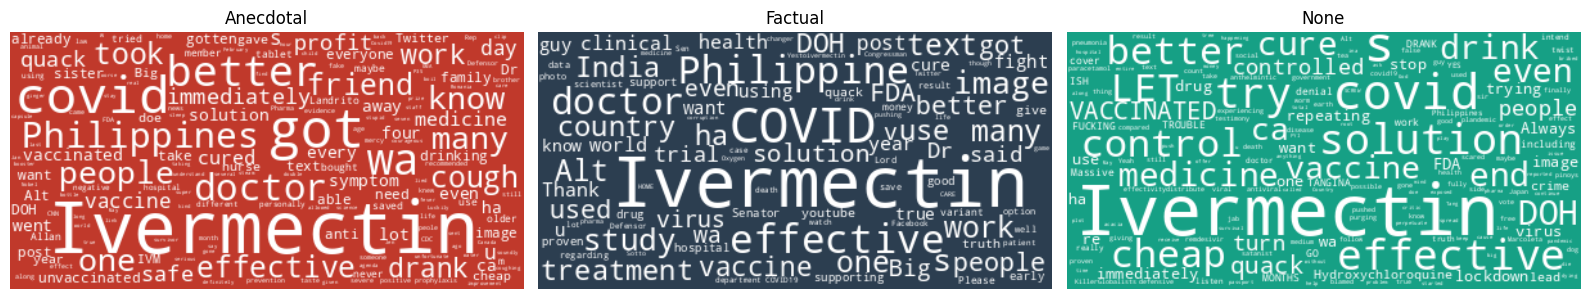

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

punctuations = ['!','.','?','(',')',',','-','&','#','%','{','}','@', '\'', 'n\'t', '..']
sentiment_groups = df_senti.groupby('sentiment')
sentiment_colors = ['#c0392b', '#2c3e50', '#16a085']
stopwords = set(STOPWORDS)
# stop_words = set(stopwords.words('english'))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

# Generate word cloud for each sentiment
for ax, (sentiment, group), color in zip(axes, sentiment_groups, sentiment_colors):
  text = group['tweet'].str.cat(sep=' ')

  # Preprocess text
  tokens = word_tokenize(text)

  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  filtered_tokens = [token for token in lemmatized_tokens if token.lower() not in stop_words]
  filtered_tokens = [token for token in filtered_tokens if token.lower() not in punctuations]

  # print(lemmatized_tokens)
  wordcloud = WordCloud(background_color=color,
                        color_func=lambda *args, **kwargs: 'white',
                        prefer_horizontal=1.0,
                        collocations=False).generate(' '.join(filtered_tokens))

  ax.imshow(wordcloud, interpolation='bilinear')
  # ax.set_title(f'{sentiment_labels[sentiment]}')
  ax.set_title(f'{sentiment}')
  ax.axis('off')

plt.tight_layout()
plt.show()

## Train the model using the training data.

In [ ]:
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import string
from nltk.stem import PorterStemmer


# Prepare datasets
df_senti = df_senti.dropna()
df_senti = df_senti[df_senti['sentiment'] != "None"]
X = df_senti['tweet']
y = df_senti['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Define NLP preprocessing steps
def custom_tokenizer(text):
  # Correct typos
  # text = str(TextBlob(text).correct()) # This may take a lot of time
  # translate the whole tweet (keep prominent words, e.g. "lugaw", "lutang")
  tokens = word_tokenize(text)
  # stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in string.punctuation]
  filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
  filtered_tokens = [token for token in tokens if token.lower() not in string.punctuation]
  return filtered_tokens

# Convert text into numerical features
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1,8), max_df=0.1, min_df=1, token_pattern=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
classifier = MultinomialNB(alpha=0.1, fit_prior=True)
classifier.fit(X_train_vec, y_train)

# # Predict the sentiment labels for the test set
y_pred = classifier.predict(X_test_vec)
metrics.accuracy_score(y_test, y_pred)

0.8823529411764706

## Evaluate the model's performance using the appropriate evaluation metrics

In [ ]:
# Print precision, recall, accuracy, fscore on test data
print('Model Evaluation')
print('Training samples:', len(y_train))
print('Test samples:', len(y_test), '\n')
print(classification_report(y_test, y_pred))

Model Evaluation
Training samples: 65
Test samples: 17 

              precision    recall  f1-score   support

   Anecdotal       0.86      0.86      0.86         7
     Factual       0.90      0.90      0.90        10

    accuracy                           0.88        17
   macro avg       0.88      0.88      0.88        17
weighted avg       0.88      0.88      0.88        17



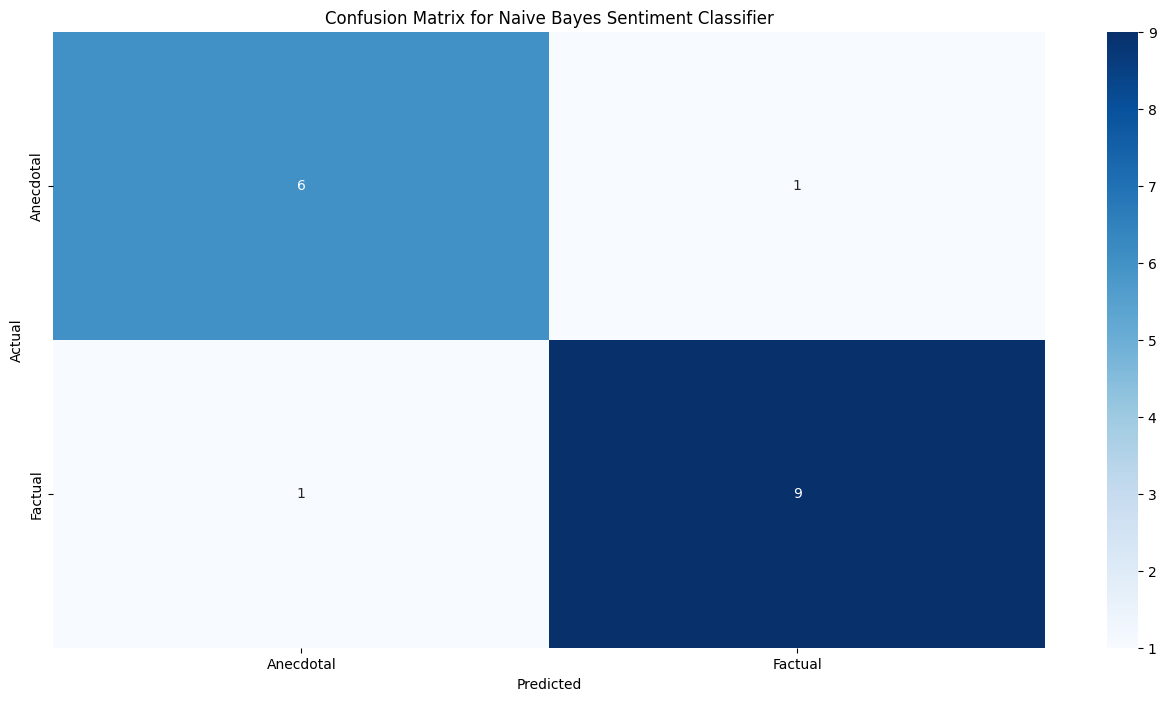

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Anecdotal', 'Factual']
plt.figure(figsize=(16, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes Sentiment Classifier')
# plt.title('Confusion Matrix for Support Vector Sentiment Classifier')
plt.show()

## Evaluation results:

In [ ]:
import numpy as np
# Classify a random tweet from the dataset
random_index = np.random.randint(0, len(df_senti))
random_tweet = df_senti['tweet'][random_index]
correct_sentiment = df_senti['sentiment'][random_index]

# For making your own tweet
# random_tweet = 'From of my friend\'s experience, Ivermectin may be effective against COVID.'
# correct_sentiment = 'Anecdotal'

predicted_sentiment = classifier.predict(vectorizer.transform([random_tweet]))


# Print the predicted and correct sentiments
print("Random Tweet:\n", random_tweet)
print("\nPredicted Sentiment:", predicted_sentiment[0])
print("Correct Sentiment:", correct_sentiment)

Random Tweet:
 There are many claims that they got better immediately with ivermectin but of course doh won't listen.. We have no kickback there.. While with vaccines.. haaay buhay..

Predicted Sentiment: Factual
Correct Sentiment: Anecdotal
